# Bankruptcy Forecasting

### Importing necessary libraries 

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, mean_squared_error, r2_score

from keras.layers import (
    Input,
    Dense,
    LSTM,
    GlobalAveragePooling1D,
    AveragePooling1D,
    TimeDistributed,
    Flatten,
    Dropout,
    Layer,
    BatchNormalization
)
from keras.models import Model
from keras.optimizers import Adam,Nadam


In [2]:
df_bank=pd.read_csv('/Users/sahanamanjunath/Desktop/Project/american_bankruptcy.csv')

In [3]:
df_bank.head()

company_name status_label  year       X1       X2      X3      X4       X5  \
0          C_1        alive  1999  511.267  833.107  18.373  89.031  336.018   
1          C_1        alive  2000  485.856  713.811  18.577  64.367  320.590   
2          C_1        alive  2001  436.656  526.477  22.496  27.207  286.588   
3          C_1        alive  2002  396.412  496.747  27.172  30.745  259.954   
4          C_1        alive  2003  432.204  523.302  26.680  47.491  247.245   

       X6       X7  ...        X9      X10      X11     X12      X13      X14  \
0  35.163  128.348  ...  1024.333  740.998  180.447  70.658  191.226  163.816   
1  18.531  115.187  ...   874.255  701.854  179.987  45.790  160.444  125.392   
2 -58.939   77.528  ...   638.721  710.199  217.699   4.711  112.244  150.464   
3 -12.410   66.322  ...   606.337  686.621  164.658   3.573  109.590  203.575   
4   3.504  104.661  ...   651.958  709.292  248.666  20.811  128.656  131.261   

       X15       X16      X17      X18  
0  201.026  1024.333  401.483  935.302  
1  204.065   874.255  361.642  809.888  
2  139.603   638.721  399.964  611.514  
3  124.106   606.337  391.633  575.592  
4  131.884   651.958  407.608  604.467  

[5 rows x 21 columns]

In [4]:
df_bank.shape

(78682, 21)

### Check for Data types

In [5]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78682 entries, 0 to 78681
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company_name  78682 non-null  object 
 1   status_label  78682 non-null  object 
 2   year          78682 non-null  int64  
 3   X1            78682 non-null  float64
 4   X2            78682 non-null  float64
 5   X3            78682 non-null  float64
 6   X4            78682 non-null  float64
 7   X5            78682 non-null  float64
 8   X6            78682 non-null  float64
 9   X7            78682 non-null  float64
 10  X8            78682 non-null  float64
 11  X9            78682 non-null  float64
 12  X10           78682 non-null  float64
 13  X11           78682 non-null  float64
 14  X12           78682 non-null  float64
 15  X13           78682 non-null  float64
 16  X14           78682 non-null  float64
 17  X15           78682 non-null  float64
 18  X16           78682 non-nu

### Check for missing values

In [6]:
df_bank.isna().sum()

company_name    0
status_label    0
year            0
X1              0
X2              0
X3              0
X4              0
X5              0
X6              0
X7              0
X8              0
X9              0
X10             0
X11             0
X12             0
X13             0
X14             0
X15             0
X16             0
X17             0
X18             0
dtype: int64

### Summary Statistics

In [7]:
df_bank.describe()

year             X1             X2            X3            X4  \
count  78682.000000   78682.000000   78682.000000  78682.000000  78682.000000   
mean    2007.506317     880.362485    1594.529029    121.234256    376.759424   
std        5.742768    3928.564794    8930.484664    652.376804   2012.023142   
min     1999.000000      -7.760000    -366.645000      0.000000 -21913.000000   
25%     2002.000000      18.924000      17.038250      1.192000     -0.811000   
50%     2007.000000     100.449500     103.661000      7.929500     15.034500   
75%     2012.000000     431.526750     634.548000     47.971750    139.655250   
max     2018.000000  169662.000000  374623.000000  28430.000000  81730.000000   

                 X5             X6            X7            X8             X9  \
count  78682.000000   78682.000000  78682.000000  7.868200e+04   78682.000000   
mean     201.605717     129.382453    286.832743  3.414355e+03    2364.019706   
std     1060.766096    1265.532022   1335.978571  1.841410e+04   11950.068842   
min        0.000000  -98696.000000     -0.006000  1.000000e-04   -1964.999000   
25%        0.000000      -7.415750      3.281250  3.498000e+01      27.548500   
50%        7.023000       1.616000     22.820000  2.275118e+02     186.598500   
75%       74.747250      40.144250    131.580500  1.244890e+03    1046.402500   
max    62567.000000  104821.000000  65812.000000  1.073391e+06  511729.000000   

                 X10            X11           X12            X13  \
count   78682.000000   78682.000000  78682.000000   78682.000000   
mean     2867.110620     722.483710    255.525035     769.490783   
std     12917.944421    3242.170946   1494.643534    3774.703114   
min         0.001000      -0.023000 -25913.000000  -21536.000000   
25%        37.363500       0.000000     -2.787000       8.521250   
50%       213.203500       7.593500      6.518000      63.581500   
75%      1171.364750     248.760750     87.599000     344.074250   
max    531864.000000  166250.000000  71230.000000  137106.000000   

                 X14            X15            X16            X17  \
count   78682.000000   78682.000000   78682.000000   78682.000000   
mean      610.072255     532.467069    2364.019706    1773.563963   
std      2938.387443    6369.159440   11950.068842    8053.684902   
min         0.001000 -102362.000000   -1964.999000       0.001000   
25%         8.889250     -68.282750      27.548500      13.486000   
50%        43.333000      -1.131000     186.598500      81.988000   
75%       222.817000     146.070000    1046.402500     629.975000   
max    116866.000000  402089.000000  511729.000000  337980.000000   

                 X18  
count   78682.000000  
mean     1987.260307  
std     10419.629038  
min      -317.197000  
25%        32.872500  
50%       168.912000  
75%       875.522250  
max    481580.000000

## Analyzing the features using SQL queries

In [145]:
from pandasql import sqldf

### Calculating Financial Ratios

Financial ratios are crucial for assessing the financial health of a company and can be predictive of bankruptcy.

In [146]:
sqldf('''SELECT
    company_name,
    Year,
    X16 AS Total_Revenue,
    X13 AS Gross_Profit,
    X4 AS EBITDA,
    X12 AS EBIT,
    X6 AS Net_Income,
    (X13 / X16) AS Gross_Margin,
    (X4 / X16) AS EBITDA_Margin,
    (X12 / X16) AS EBIT_Margin,
    (X6 / X16) AS Net_Margin,
    (X11 / (X11 + X17)) AS Debt_to_Equity
FROM
    df_bank;''')

company_name  year  Total_Revenue  Gross_Profit   EBITDA     EBIT  \
0              C_1  1999       1024.333       191.226   89.031   70.658   
1              C_1  2000        874.255       160.444   64.367   45.790   
2              C_1  2001        638.721       112.244   27.207    4.711   
3              C_1  2002        606.337       109.590   30.745    3.573   
4              C_1  2003        651.958       128.656   47.491   20.811   
...            ...   ...            ...           ...      ...      ...   
78677       C_8971  2014        104.223        60.885   45.615   31.521   
78678       C_8971  2015        291.153       231.969  202.133  159.541   
78679       C_8971  2016        169.858       100.784   79.051   13.994   
78680       C_8971  2017        161.884        95.357   69.171    3.841   
78681       C_8971  2018        160.513        91.696   67.262    2.061   

       Net_Income  Gross_Margin  EBITDA_Margin  EBIT_Margin  Net_Margin  \
0          35.163      0.186683       0.086916     0.068980    0.034328   
1          18.531      0.183521       0.073625     0.052376    0.021196   
2         -58.939      0.175732       0.042596     0.007376   -0.092277   
3         -12.410      0.180741       0.050706     0.005893   -0.020467   
4           3.504      0.197338       0.072844     0.031921    0.005375   
...           ...           ...            ...          ...         ...   
78677      25.261      0.584180       0.437667     0.302438    0.242375   
78678     129.688      0.796725       0.694250     0.547963    0.445429   
78679      -1.442      0.593343       0.465395     0.082386   -0.008489   
78680     -20.401      0.589045       0.427287     0.023727   -0.126022   
78681     -50.946      0.571268       0.419044     0.012840   -0.317395   

       Debt_to_Equity  
0            0.310084  
1            0.332307  
2            0.352456  
3            0.295993  
4            0.378906  
...               ...  
78677        0.449798  
78678        0.466607  
78679        0.470346  
78680        0.471898  
78681        0.470046  

[78682 rows x 12 columns]

### 2. Year-over-Year Growth for Key Metrics

Analyzing how financial metrics are growing or shrinking year-over-year can be indicative of a company's trajectory.

In [147]:
sqldf('''WITH Yearly_Data AS (
    SELECT
        company_name,
        year AS Year,
        SUM(X16) AS Total_Revenue,
        SUM(X6) AS Net_Income
    FROM
        df_bank
    GROUP BY
        company_name, year
)
SELECT
    Current.company_name,
    Current.Year,
    Current.Total_Revenue,
    Current.Net_Income,
    ((Current.Total_Revenue - Previous.Total_Revenue) / Previous.Total_Revenue) * 100 AS Revenue_Growth,
    ((Current.Net_Income - Previous.Net_Income) / Previous.Net_Income) * 100 AS Income_Growth
FROM
    Yearly_Data AS Current
INNER JOIN
    Yearly_Data AS Previous ON Current.company_name = Previous.company_name AND Current.Year = Previous.Year + 1;''')


company_name  Year  Total_Revenue  Net_Income  Revenue_Growth  \
0              C_1  2000        874.255      18.531      -14.651290   
1              C_1  2001        638.721     -58.939      -26.941110   
2              C_1  2002        606.337     -12.410       -5.070132   
3              C_1  2003        651.958       3.504        7.524034   
4              C_1  2004        747.848      15.453       14.708003   
...            ...   ...            ...         ...             ...   
68896        C_999  2014      27441.300    4757.800       -2.363933   
68897        C_999  2015      25413.000    4529.300       -7.391414   
68898        C_999  2016      24621.900    4686.500       -3.112974   
68899        C_999  2017      22820.400    5192.300       -7.316657   
68900        C_999  2018      21025.200    5924.300       -7.866646   

       Income_Growth  
0         -47.299718  
1        -418.056230  
2         -78.944332  
3        -128.235294  
4         341.010274  
...              ...  
68896     -14.824827  
68897      -4.802640  
68898       3.470735  
68899      10.792702  
68900      14.097799  

[68901 rows x 6 columns]

### 3. Aggregate Expense Ratios
Understanding how expenses compare to revenues can help identify financial stress.

In [148]:
sqldf('''SELECT
    company_name,year,
    SUM(X18) AS Total_Operating_Expenses,
    SUM(X16) AS Total_Revenue,
    (SUM(X18) / 
    SUM(X16)) * 100 AS Expense_Ratio
FROM
    df_bank
GROUP BY
    company_name,year;''')


company_name  year  Total_Operating_Expenses  Total_Revenue  \
0              C_1  1999                   935.302       1024.333   
1              C_1  2000                   809.888        874.255   
2              C_1  2001                   611.514        638.721   
3              C_1  2002                   575.592        606.337   
4              C_1  2003                   604.467        651.958   
...            ...   ...                       ...            ...   
78677        C_999  2014                 17934.200      27441.300   
78678        C_999  2015                 16620.100      25413.000   
78679        C_999  2016                 15411.000      24621.900   
78680        C_999  2017                 13203.400      22820.400   
78681        C_999  2018                 11136.500      21025.200   

       Expense_Ratio  
0          91.308393  
1          92.637503  
2          95.740394  
3          94.929387  
4          92.715635  
...              ...  
78677      65.354775  
78678      65.399992  
78679      62.590621  
78680      57.857882  
78681      52.967392  

[78682 rows x 5 columns]

### 4. Liquidity and Operational Efficiency Metrics
Metrics such as Quick Ratio and Inventory Turnover can be very telling.

In [149]:
sqldf('''SELECT
    company_name,
    (SUM(X1) - SUM(X5)) / SUM(X14) AS Quick_Ratio,
    SUM(X9) / SUM(X5) AS Inventory_Turnover
FROM
    df_bank
GROUP BY
    company_name;''')


company_name  Quick_Ratio  Inventory_Turnover
0             C_1     1.121566            3.040013
1            C_10     0.580671           16.402675
2           C_100     2.992164           37.500532
3          C_1000     1.018626           25.597296
4          C_1001     0.635007           11.670945
...           ...          ...                 ...
8966        C_995     0.779287            9.555484
8967        C_996     0.646011            2.455065
8968        C_997     0.536918            6.648406
8969        C_998     0.887122           10.610950
8970        C_999     1.239651          199.971654

[8971 rows x 3 columns]

### 5. Market Performance Metrics
Comparing market value with various financial figures can provide insights into market perceptions.

In [150]:
sqldf('''SELECT
    company_name,
    X8 AS Market_Capitalization,
    X16 AS Total_Revenue,
    (X8 / X16) AS Market_to_Revenue_Ratio,
    (X8 / X6) AS PE_Ratio
FROM
    df_bank;''')


company_name  Market_Capitalization  Total_Revenue  \
0              C_1               372.7519       1024.333   
1              C_1               377.1180        874.255   
2              C_1               364.5928        638.721   
3              C_1               143.3295        606.337   
4              C_1               308.9071        651.958   
...            ...                    ...            ...   
78677       C_8971               756.4827        104.223   
78678       C_8971               527.5750        291.153   
78679       C_8971               578.8868        169.858   
78680       C_8971               412.6241        161.884   
78681       C_8971               354.1786        160.513   

       Market_to_Revenue_Ratio    PE_Ratio  
0                     0.363897   10.600685  
1                     0.431359   20.350656  
2                     0.570817   -6.185935  
3                     0.236386  -11.549517  
4                     0.473814   88.158419  
...                        ...         ...  
78677                 7.258309   29.946665  
78678                 1.812020    4.068033  
78679                 3.408063 -401.447157  
78680                 2.548887  -20.225680  
78681                 2.206542   -6.952039  

[78682 rows x 5 columns]

### 6. Segmenting Data for Comparative Analysis
Segment companies by size, industry, or performance and compare metrics across these segments.

In [151]:
sqldf('''SELECT
    company_name,
    AVG(X16) AS Avg_Revenue,
    AVG(X6) AS Avg_Net_Income,
    AVG(X11) AS Avg_LongTerm_Debt
FROM
    df_bank
GROUP BY
    company_name;''')


company_name    Avg_Revenue  Avg_Net_Income  Avg_LongTerm_Debt
0             C_1    1341.480579       36.263000         303.541421
1            C_10    3330.050650      314.561700        3128.634750
2           C_100      63.418400       22.602200           0.966667
3          C_1000    5460.389600      882.498700        1215.807250
4          C_1001  115997.700000     1049.510000        3668.255000
...           ...            ...             ...                ...
8966        C_995    4567.920000      113.600714         695.814286
8967        C_996     124.424333       -0.297667          43.374667
8968        C_997    3328.890000      322.955000        1040.790000
8969        C_998    3296.034850      -71.268200         415.282450
8970        C_999   21657.930000     3710.060000       13592.025000

[8971 rows x 4 columns]

### 7. Temporal Trends and Seasonality

Examine how financials change with seasons or across years.

In [152]:
sqldf('''SELECT
    company_name,year,
    AVG(X16) AS Avg_Monthly_Revenue,
    AVG(X6) AS Avg_Monthly_Net_Income
FROM
    df_bank
GROUP BY
    company_name,year;''')


company_name  year  Avg_Monthly_Revenue  Avg_Monthly_Net_Income
0              C_1  1999             1024.333                  35.163
1              C_1  2000              874.255                  18.531
2              C_1  2001              638.721                 -58.939
3              C_1  2002              606.337                 -12.410
4              C_1  2003              651.958                   3.504
...            ...   ...                  ...                     ...
78677        C_999  2014            27441.300                4757.800
78678        C_999  2015            25413.000                4529.300
78679        C_999  2016            24621.900                4686.500
78680        C_999  2017            22820.400                5192.300
78681        C_999  2018            21025.200                5924.300

[78682 rows x 4 columns]

In [153]:
sqldf('''SELECT
    company_name,year,
    count(distinct status_label) as status
    
FROM
    df_bank
GROUP BY
    company_name,year
    order by count(distinct status_label) desc;''')


company_name  year  status
0              C_1  1999       1
1              C_1  2000       1
2              C_1  2001       1
3              C_1  2002       1
4              C_1  2003       1
...            ...   ...     ...
78677        C_999  2014       1
78678        C_999  2015       1
78679        C_999  2016       1
78680        C_999  2017       1
78681        C_999  2018       1

[78682 rows x 3 columns]

### Visualizations to understand the relationship between different features and target 

### Total Revenue vs Gross Profit by Bankruptcy Status

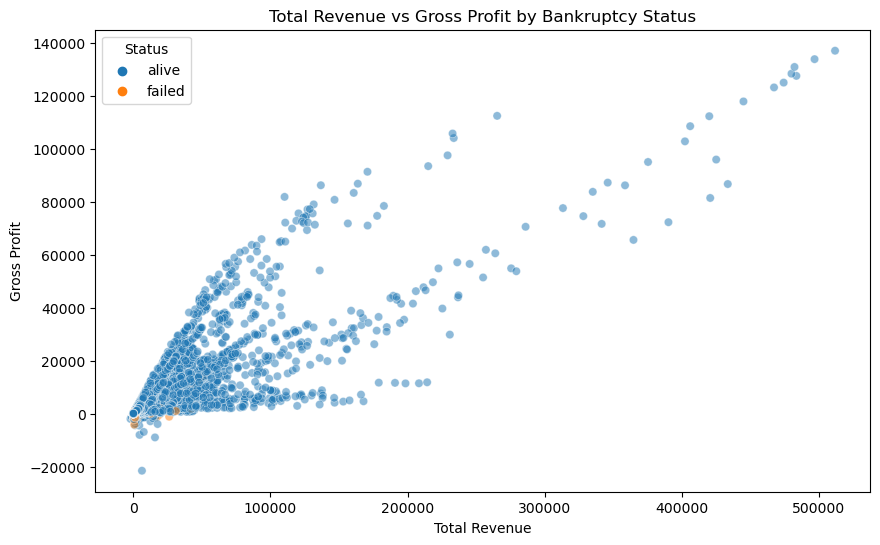

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame
# import pandas as pd
# data = {'X16': [1, 2, 3, 4, 5], 'X13': [5, 4, 3, 2, 1], 'status_label': ['A', 'B', 'A', 'B', 'A']}
# df_bank = pd.DataFrame(data)

# Scatter plot with transparency
plt.figure(figsize=(10, 6))
sns.scatterplot(x='X16', y='X13', hue='status_label', data=df_bank, alpha=0.5)  # Adjust alpha here
plt.title('Total Revenue vs Gross Profit by Bankruptcy Status')
plt.xlabel('Total Revenue')
plt.ylabel('Gross Profit')
plt.legend(title='Status')
plt.show()


### Cost of goods sold vs Net Sales by Bankruptcy Status

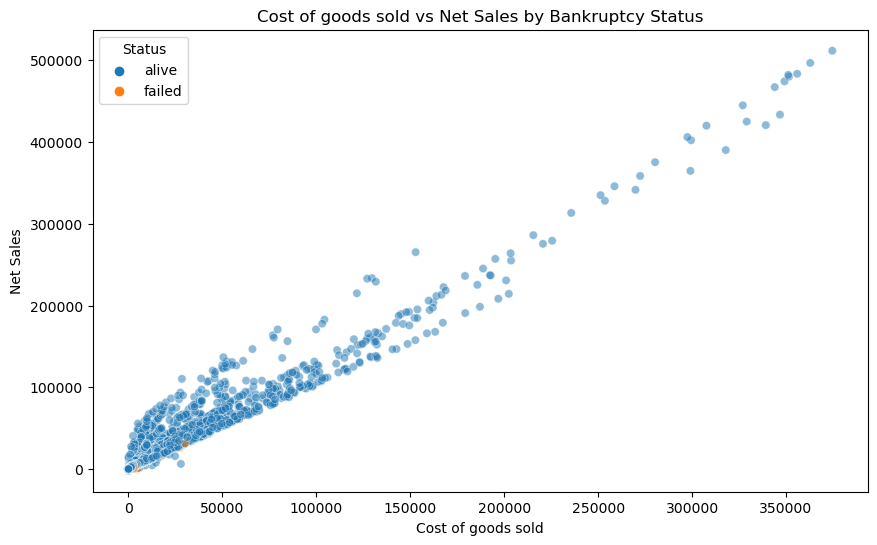

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='X2', y='X9', hue='status_label', data=df_bank,alpha=0.5)
plt.title('Cost of goods sold vs Net Sales by Bankruptcy Status')
plt.xlabel('Cost of goods sold')
plt.ylabel('Net Sales')
plt.legend(title='Status')
plt.show()

### Depreciation and Amortization vs Net Income by Bankruptcy Status

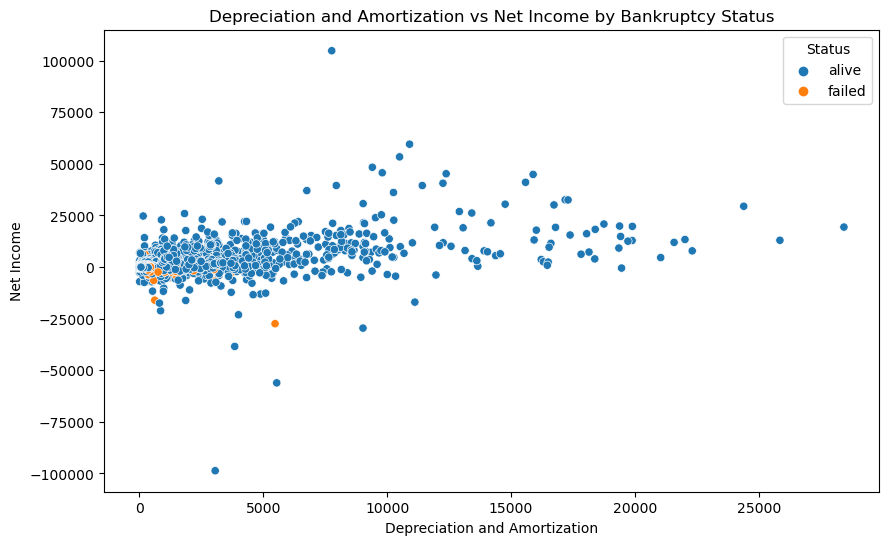

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='X3', y='X6', hue='status_label', data=df_bank)
plt.title('Depreciation and Amortization vs Net Income by Bankruptcy Status')
plt.xlabel('Depreciation and Amortization')
plt.ylabel('Net Income')
plt.legend(title='Status')
plt.savefig('/Users/sahanamanjunath/Downloads/1.png')
plt.show()



### Cost of goods sold vs Income after expenses by Bankruptcy Status

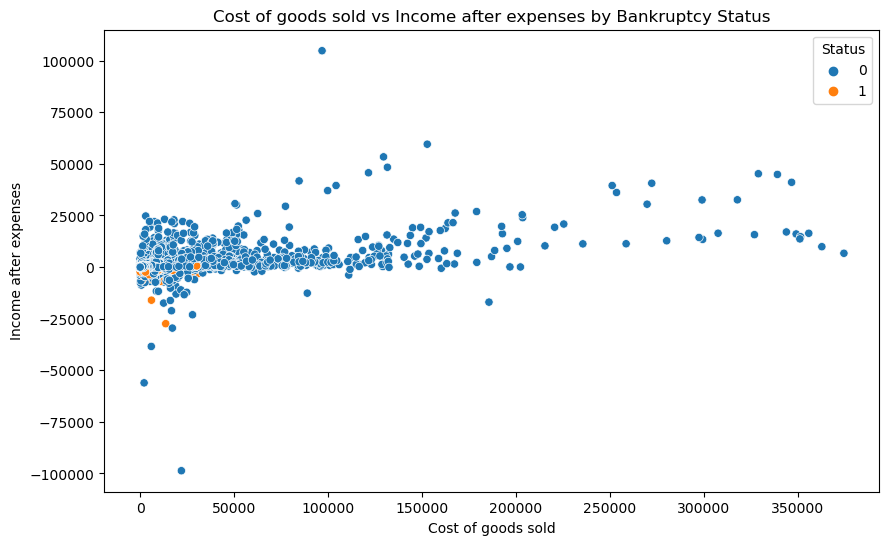

In [358]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='X2', y='X6', hue='status_label', data=df_bank)
plt.title('Cost of goods sold vs Income after expenses by Bankruptcy Status')
plt.xlabel('Cost of goods sold')
plt.ylabel('Income after expenses')
plt.legend(title='Status')
plt.savefig('/Users/sahanamanjunath/Downloads/2.png')
plt.show()

### Net Sales vs Gross Profit by Bankruptcy Status

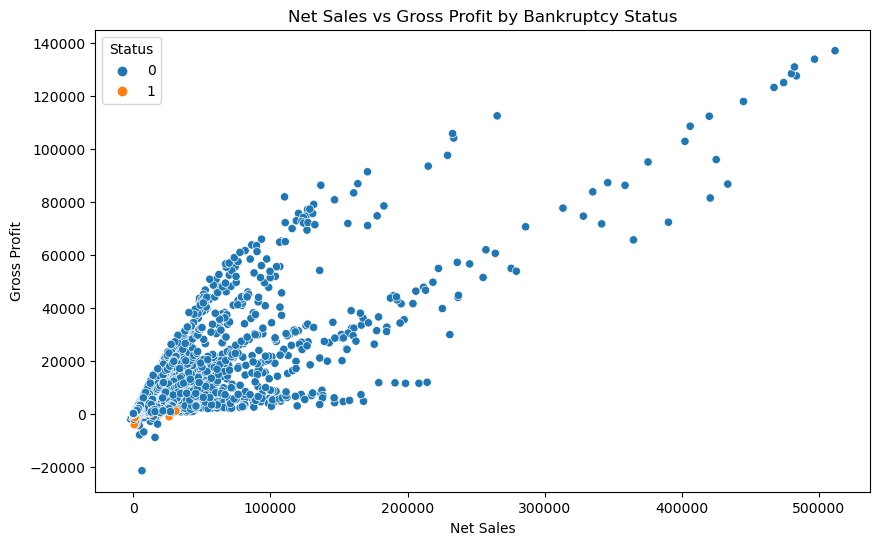

In [359]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='X9', y='X13', hue='status_label', data=df_bank)
plt.title('Net Sales vs Gross Profit by Bankruptcy Status')
plt.xlabel('Net Sales')
plt.ylabel('Gross Profit')
plt.legend(title='Status')
plt.savefig('/Users/sahanamanjunath/Downloads/3.png')
plt.show()


### Retained Earnings vs Total Current Liabilities by Bankruptcy Status

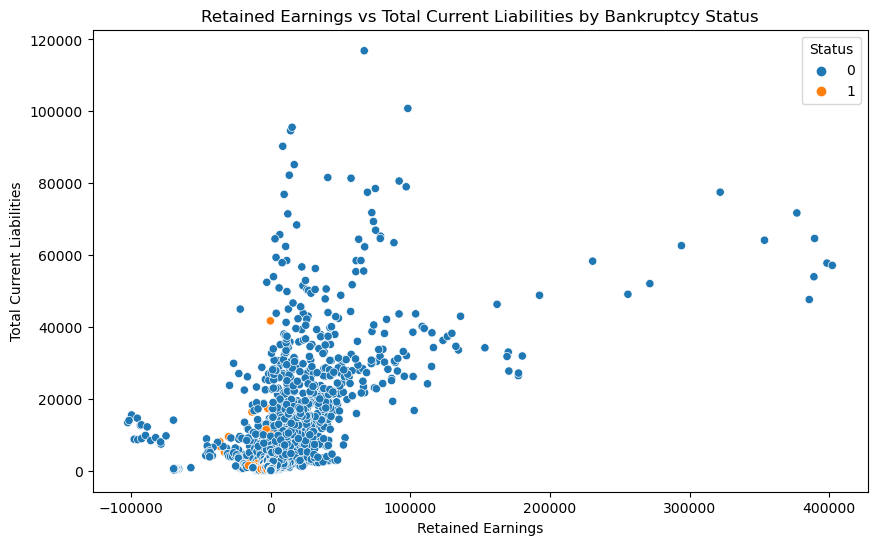

In [360]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='X15', y='X14', hue='status_label', data=df_bank)
plt.title('Retained Earnings vs Total Current Liabilities by Bankruptcy Status')
plt.xlabel('Retained Earnings')
plt.ylabel('Total Current Liabilities')
plt.legend(title='Status')
plt.savefig('/Users/sahanamanjunath/Downloads/4.png')
plt.show()


### Total Liabilities vs Current Liabilities by Bankruptcy Status

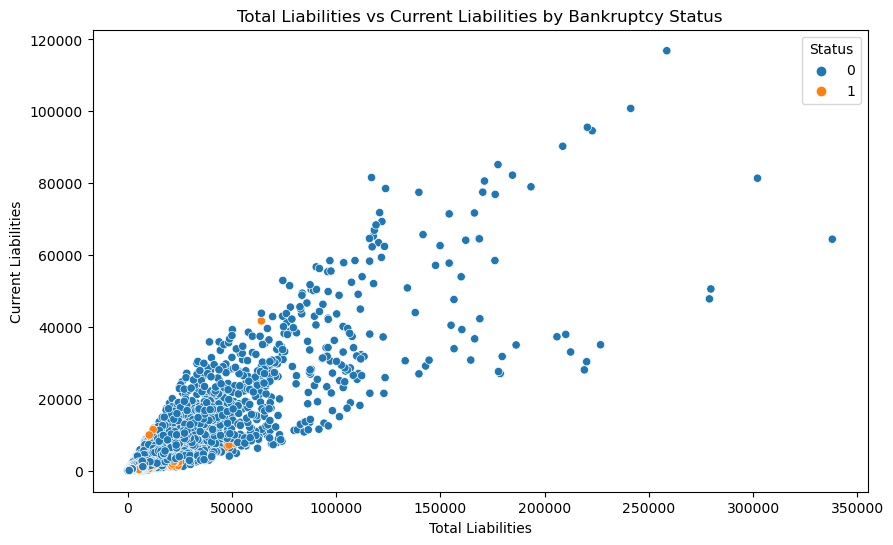

In [341]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='X17', y='X14', hue='status_label', data=df_bank)
plt.title('Total Liabilities vs Current Liabilities by Bankruptcy Status')
plt.xlabel('Total Liabilities')
plt.ylabel('Current Liabilities')
plt.legend(title='Status')
plt.show()

### Total Liabilities vs Market Value by Bankruptcy Status

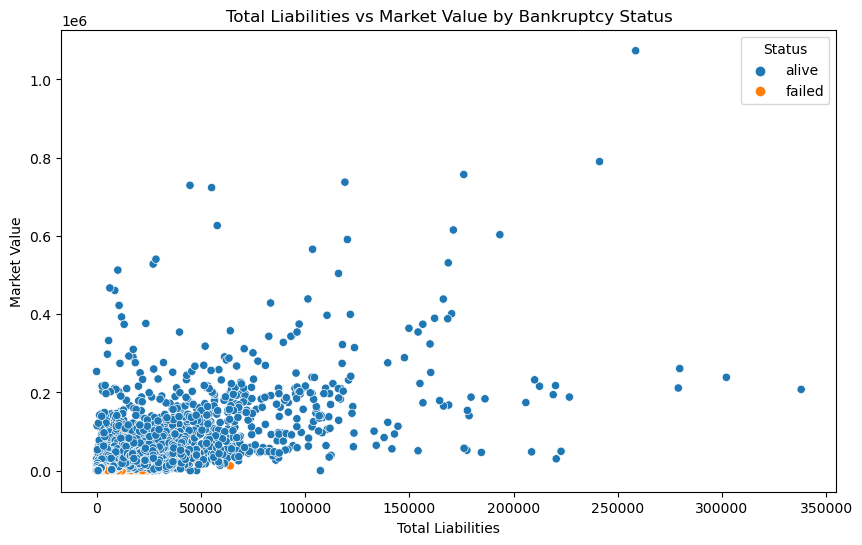

In [159]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='X17', y='X8', hue='status_label', data=df_bank)
plt.title('Total Liabilities vs Market Value by Bankruptcy Status')
plt.xlabel('Total Liabilities')
plt.ylabel('Market Value')
plt.legend(title='Status')
plt.show()

## Data Preprocessing  

### Handling highly imbalanced classes 

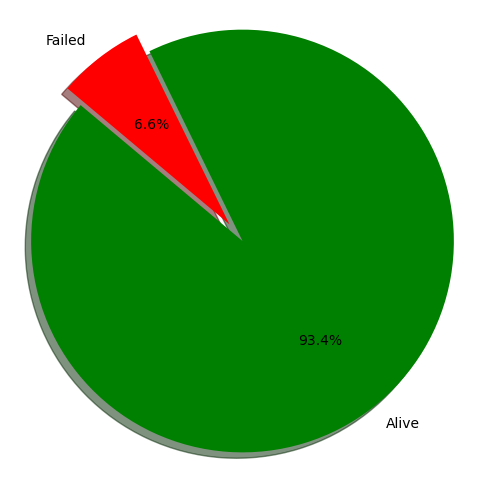

In [14]:
# Given counts and ratios
alive_count = df_bank['status_label'].value_counts()['alive']
failed_count = df_bank['status_label'].value_counts()['failed']
total_count = alive_count + failed_count
alive_ratio = alive_count / total_count
failed_ratio = failed_count / total_count

# Data for the pie chart
labels = ['Alive', 'Failed']
sizes = [alive_ratio, failed_ratio]
colors = ['green', 'red']
explode = (0.1, 0)  # Explode the first slice

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

# Save the pie chart as a PNG image
plt.savefig('pie_chart.png', bbox_inches='tight', dpi=300)
plt.show()

In [16]:
df_bank['status_label'] = [0 if i=='alive' else 1 for i in df_bank['status_label']]

In [17]:
from sklearn.utils import resample

#create two different dataframe of majority and minority class
df_majority = df_bank[(df_bank['status_label']==0)]
df_minority = df_bank[(df_bank['status_label']==1)]


# Calculate the number of samples needed for the minority class to achieve a 60/40 ratio.
majority_size = len(df_majority)
total_target_size = majority_size / 0.6  # Majority is 60% of the total
minority_target_size = total_target_size - majority_size  # Minority will be 40% of the total

# Upsample minority class to the calculated target size
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=int(minority_target_size), # to match the new minority size
                                 random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

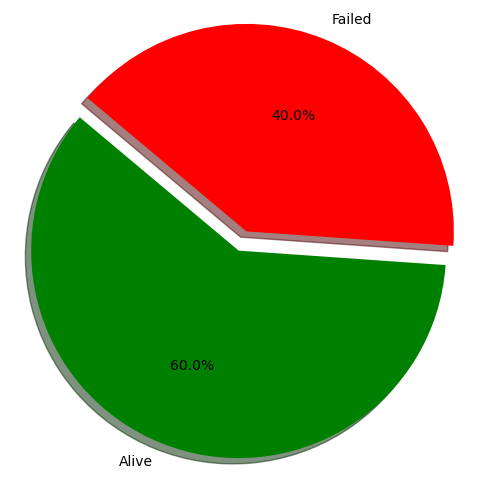

In [18]:
import matplotlib.pyplot as plt

alive_count = df_balanced['status_label'].value_counts()[0]
failed_count = df_balanced['status_label'].value_counts()[1]
total_count = alive_count + failed_count
alive_ratio = alive_count / total_count
failed_ratio = failed_count / total_count

# Data for the pie chart
labels = ['Alive', 'Failed']
sizes = [alive_ratio, failed_ratio]
colors = ['green', 'red']
explode = (0.1, 0)  # Explode the first slice

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

# Save the pie chart as a PNG image
plt.show()

In [19]:
df_bank=df_balanced

In [20]:
df_bank.shape

(122436, 21)

### Dropping Multicollinear features 

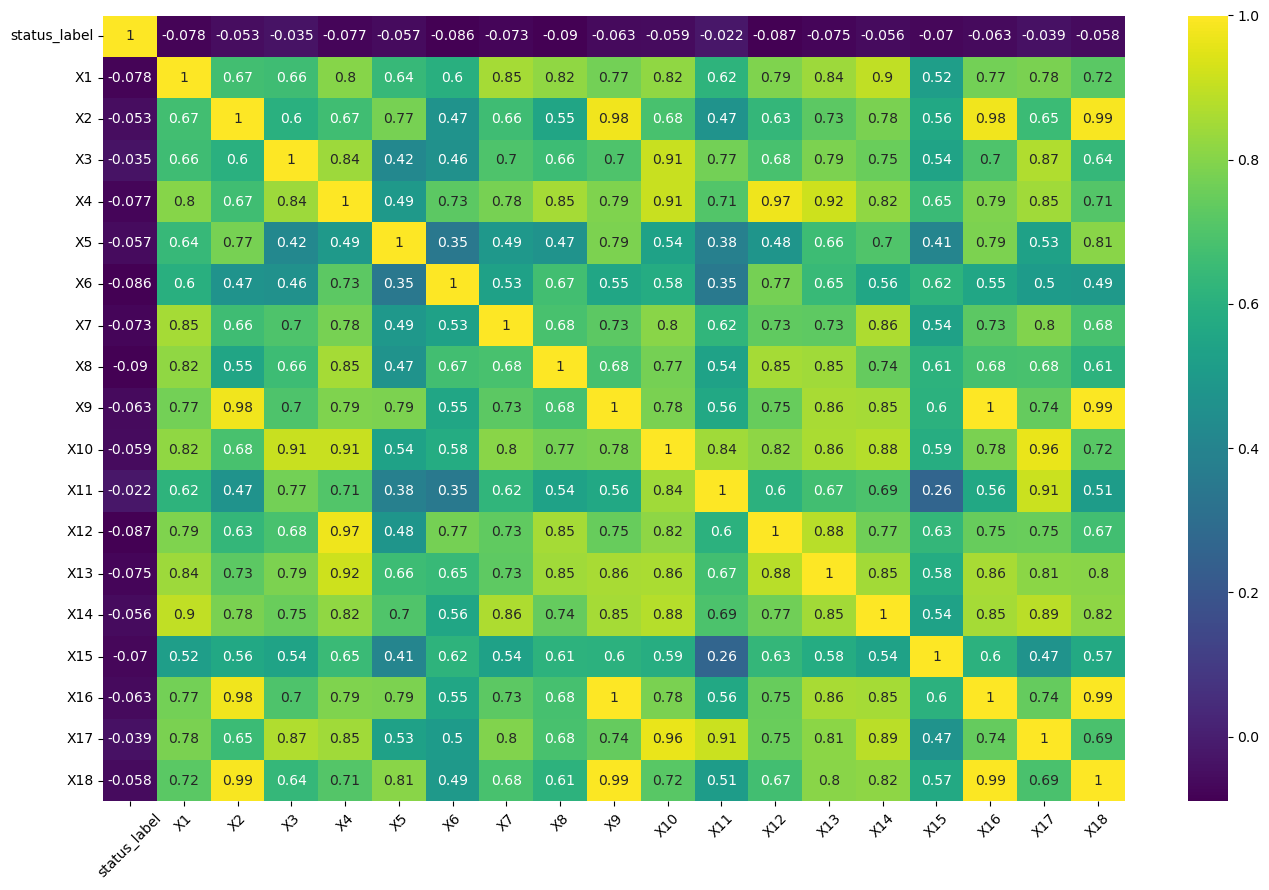

In [21]:
plt.figure(figsize=(14, 9))
sns.heatmap(df_bank.drop(["year"], axis=1).corr(numeric_only=True), annot=True, cmap="viridis")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

X4 shows EBITDA - Earnings before interest, taxes, depreciation, and amortization. It is a measure of a company's and X12 shows EBIT - Earnings before interest and taxes.So we keep X12 because it gives more information regarding bankruptcy.

In [22]:
df_bank = df_bank.drop("X4", axis=1)

X2 "Cost of goods sold" and X9 "Net sales" are strongly correlated, but not the same factor. However, X13 "Gross profit" is actually equal net sales subtracted cost of goods sold, X9 - X2, so this feature can be dropped to decrease multicollinearity.

In [23]:
df_bank = df_bank.drop("X13", axis=1)

X9 "Net sales" and X16 "Total revenue" are identical and therefore perfectly correlated. Dropping one to decrease multicollinearity.

In [24]:
df_bank = df_bank.drop("X16", axis=1)

X2 refers to Cost of goods sold - The total amount a company paid as a cost directly related to the sale of products and X18 is Total Operating Expenses - The expenses a business incurs through its normal business operations. So keep X18

There is also a near-perfect correlation between X2 "Cost of goods sold" and X18 "Total Operating Expenses". It seems that X2 is a subset of all expenses covered in X18, thus we can create a new variable X19 "Other costs" = X18 - X2, which relates to all non-goods cost, and X18 will then be dropped to reduce multicollinearity.

In [25]:
df_bank["X19"] = df_bank["X18"] - df_bank["X2"]

X10 "Total assets" and X17 "Total liabilities" are also very strong correlated. Knowing that equity = assets - liabilities, it makes sense that the two predictors are strongly correlated if companies operate with similar equity ratios, however it is not clear that one can/should be dropped.

## Feature Engineering 

### Scaling the features

In [26]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
df_bank.iloc[:,3:]=sc.fit_transform(df_bank.iloc[:,3:])
df_bank.head()  #z=x-u/s

company_name  status_label  year        X1        X2        X3        X5  \
0          C_1             0  1999 -0.061201 -0.067474 -0.164257  0.188829   
1          C_1             0  2000 -0.069063 -0.083691 -0.163883  0.171652   
2          C_1             0  2001 -0.084286 -0.109155 -0.156713  0.133795   
3          C_1             0  2002 -0.096737 -0.113197 -0.148157  0.104141   
4          C_1             0  2003 -0.085663 -0.109587 -0.149057  0.089990   

         X6        X7        X8        X9       X10       X11       X12  \
0 -0.029498 -0.093742 -0.142208 -0.093243 -0.155899 -0.173441 -0.091665   
1 -0.044981 -0.105671 -0.141916 -0.108512 -0.159515 -0.173601 -0.112004   
2 -0.117098 -0.139805 -0.142753 -0.132474 -0.158744 -0.160483 -0.145601   
3 -0.073784 -0.149963 -0.157534 -0.135768 -0.160922 -0.178933 -0.146532   
4 -0.058969 -0.115212 -0.146473 -0.131127 -0.158828 -0.149711 -0.132433   

        X14       X15       X17       X18       X19  
0 -0.142205 -0.015344 -0.171215 -0.083165 -0.127655  
1 -0.157760 -0.014765 -0.176970 -0.097759 -0.131232  
2 -0.147610 -0.027053 -0.171434 -0.120843 -0.137688  
3 -0.126109 -0.030007 -0.172638 -0.125023 -0.141309  
4 -0.155384 -0.028525 -0.170330 -0.121663 -0.139952

### Creating new column for Global crisis 

In [27]:
df_bank['year'] = pd.to_datetime(df_bank['year'], format='%Y')
df_bank['crisis_status'] = df_bank['year'].dt.year.apply(lambda x: 1 if 2008 <= x <= 2010 else 0)
df_bank

company_name  status_label       year        X1        X2        X3  \
0              C_1             0 1999-01-01 -0.061201 -0.067474 -0.164257   
1              C_1             0 2000-01-01 -0.069063 -0.083691 -0.163883   
2              C_1             0 2001-01-01 -0.084286 -0.109155 -0.156713   
3              C_1             0 2002-01-01 -0.096737 -0.113197 -0.148157   
4              C_1             0 2003-01-01 -0.085663 -0.109587 -0.149057   
...            ...           ...        ...       ...       ...       ...   
38434       C_3953             1 1999-01-01 -0.217353 -0.180704 -0.197437   
34267       C_3445             1 2014-01-01 -0.218768 -0.180531 -0.197862   
49434       C_5221             1 2003-01-01 -0.213577 -0.179097 -0.196047   
3134         C_258             1 2010-01-01 -0.204058 -0.141536 -0.188406   
48159       C_5069             1 2017-01-01  0.096166  0.612071  0.105516   

             X5        X6        X7        X8        X9       X10       X11  \
0      0.188829 -0.029498 -0.093742 -0.142208 -0.093243 -0.155899 -0.173441   
1      0.171652 -0.044981 -0.105671 -0.141916 -0.108512 -0.159515 -0.173601   
2      0.133795 -0.117098 -0.139805 -0.142753 -0.132474 -0.158744 -0.160483   
3      0.104141 -0.073784 -0.149963 -0.157534 -0.135768 -0.160922 -0.178933   
4      0.089990 -0.058969 -0.115212 -0.146473 -0.131127 -0.158828 -0.149711   
...         ...       ...       ...       ...       ...       ...       ...   
38434 -0.185247 -0.065887 -0.209914 -0.164582 -0.197321 -0.223730 -0.236209   
34267 -0.185289 -0.062450 -0.210067 -0.165029 -0.197226 -0.224170 -0.236209   
49434 -0.182917 -0.079531 -0.205650 -0.148917 -0.196335 -0.222433 -0.236209   
3134  -0.149672 -0.062758 -0.195681 -0.165194 -0.165906 -0.216013 -0.230546   
48159  0.124303 -0.004899  0.404433 -0.096740  0.595573  0.006962  0.081053   

            X12       X14       X15       X17       X18       X19  \
0     -0.091665 -0.142205 -0.015344 -0.171215 -0.083165 -0.127655   
1     -0.112004 -0.157760 -0.014765 -0.176970 -0.097759 -0.131232   
2     -0.145601 -0.147610 -0.027053 -0.171434 -0.120843 -0.137688   
3     -0.146532 -0.126109 -0.030007 -0.172638 -0.125023 -0.141309   
4     -0.132433 -0.155384 -0.028525 -0.170330 -0.121663 -0.139952   
...         ...       ...       ...       ...       ...       ...   
38434 -0.152687 -0.208044 -0.063038 -0.229039 -0.191418 -0.184550   
34267 -0.149829 -0.208403 -0.069203 -0.229167 -0.191690 -0.186656   
49434 -0.164389 -0.206627 -0.082103 -0.228500 -0.188714 -0.177870   
3134  -0.148834 -0.192628 -0.048589 -0.221186 -0.156608 -0.178117   
48159 -0.019041  0.063607 -0.054465  0.037719  0.677223  0.770132   

       crisis_status  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
38434              0  
34267              0  
49434              0  
3134               1  
48159              0  

[122436 rows x 20 columns]

In [270]:
df_bank.shape

(122436, 20)

### Feature Selection

Accuracy: 0.9025645213982358
Feature Importances:
 year             0.109933
X6               0.094789
X8               0.065710
X11              0.064811
X19              0.062340
X3               0.056855
X9               0.053322
X7               0.053025
X18              0.049021
X15              0.048094
X17              0.047794
X10              0.047541
X5               0.045228
X2               0.044420
X14              0.042053
X1               0.042012
X12              0.041350
crisis_status    0.031702
dtype: float32


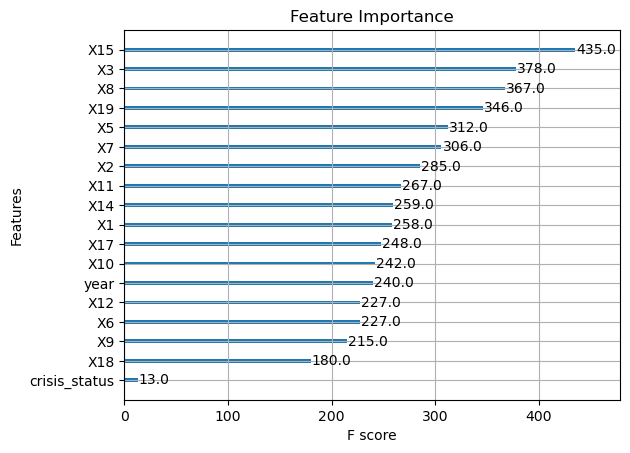

In [271]:
df = df_bank
#df['status_label'] = [0 if i=='alive' else 1 for i in df['status_label']]
import xgboost as xgb
# Convert 'year' to datetime and extract year if needed
df['year'] = pd.to_datetime(df['year']).dt.year

# Drop non-numeric and unnecessary columns for the model
X = df.drop(columns=['company_name', 'status_label'])
y = df['status_label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions (to check performance)
y_pred = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
importances = xgb_model.feature_importances_

# Create a series with feature names and importances
feature_importance_series = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Print the feature importances
print("Feature Importances:\n", feature_importance_series)

# Optionally, plot feature importances
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model)
plt.title('Feature Importance')
plt.show()

In [28]:
df_bank1 = df_bank[['X15','X3','X8','X19','X5','X7','X2','X11','X14','X1','crisis_status','year','company_name','status_label']]

### Pairplot visualization

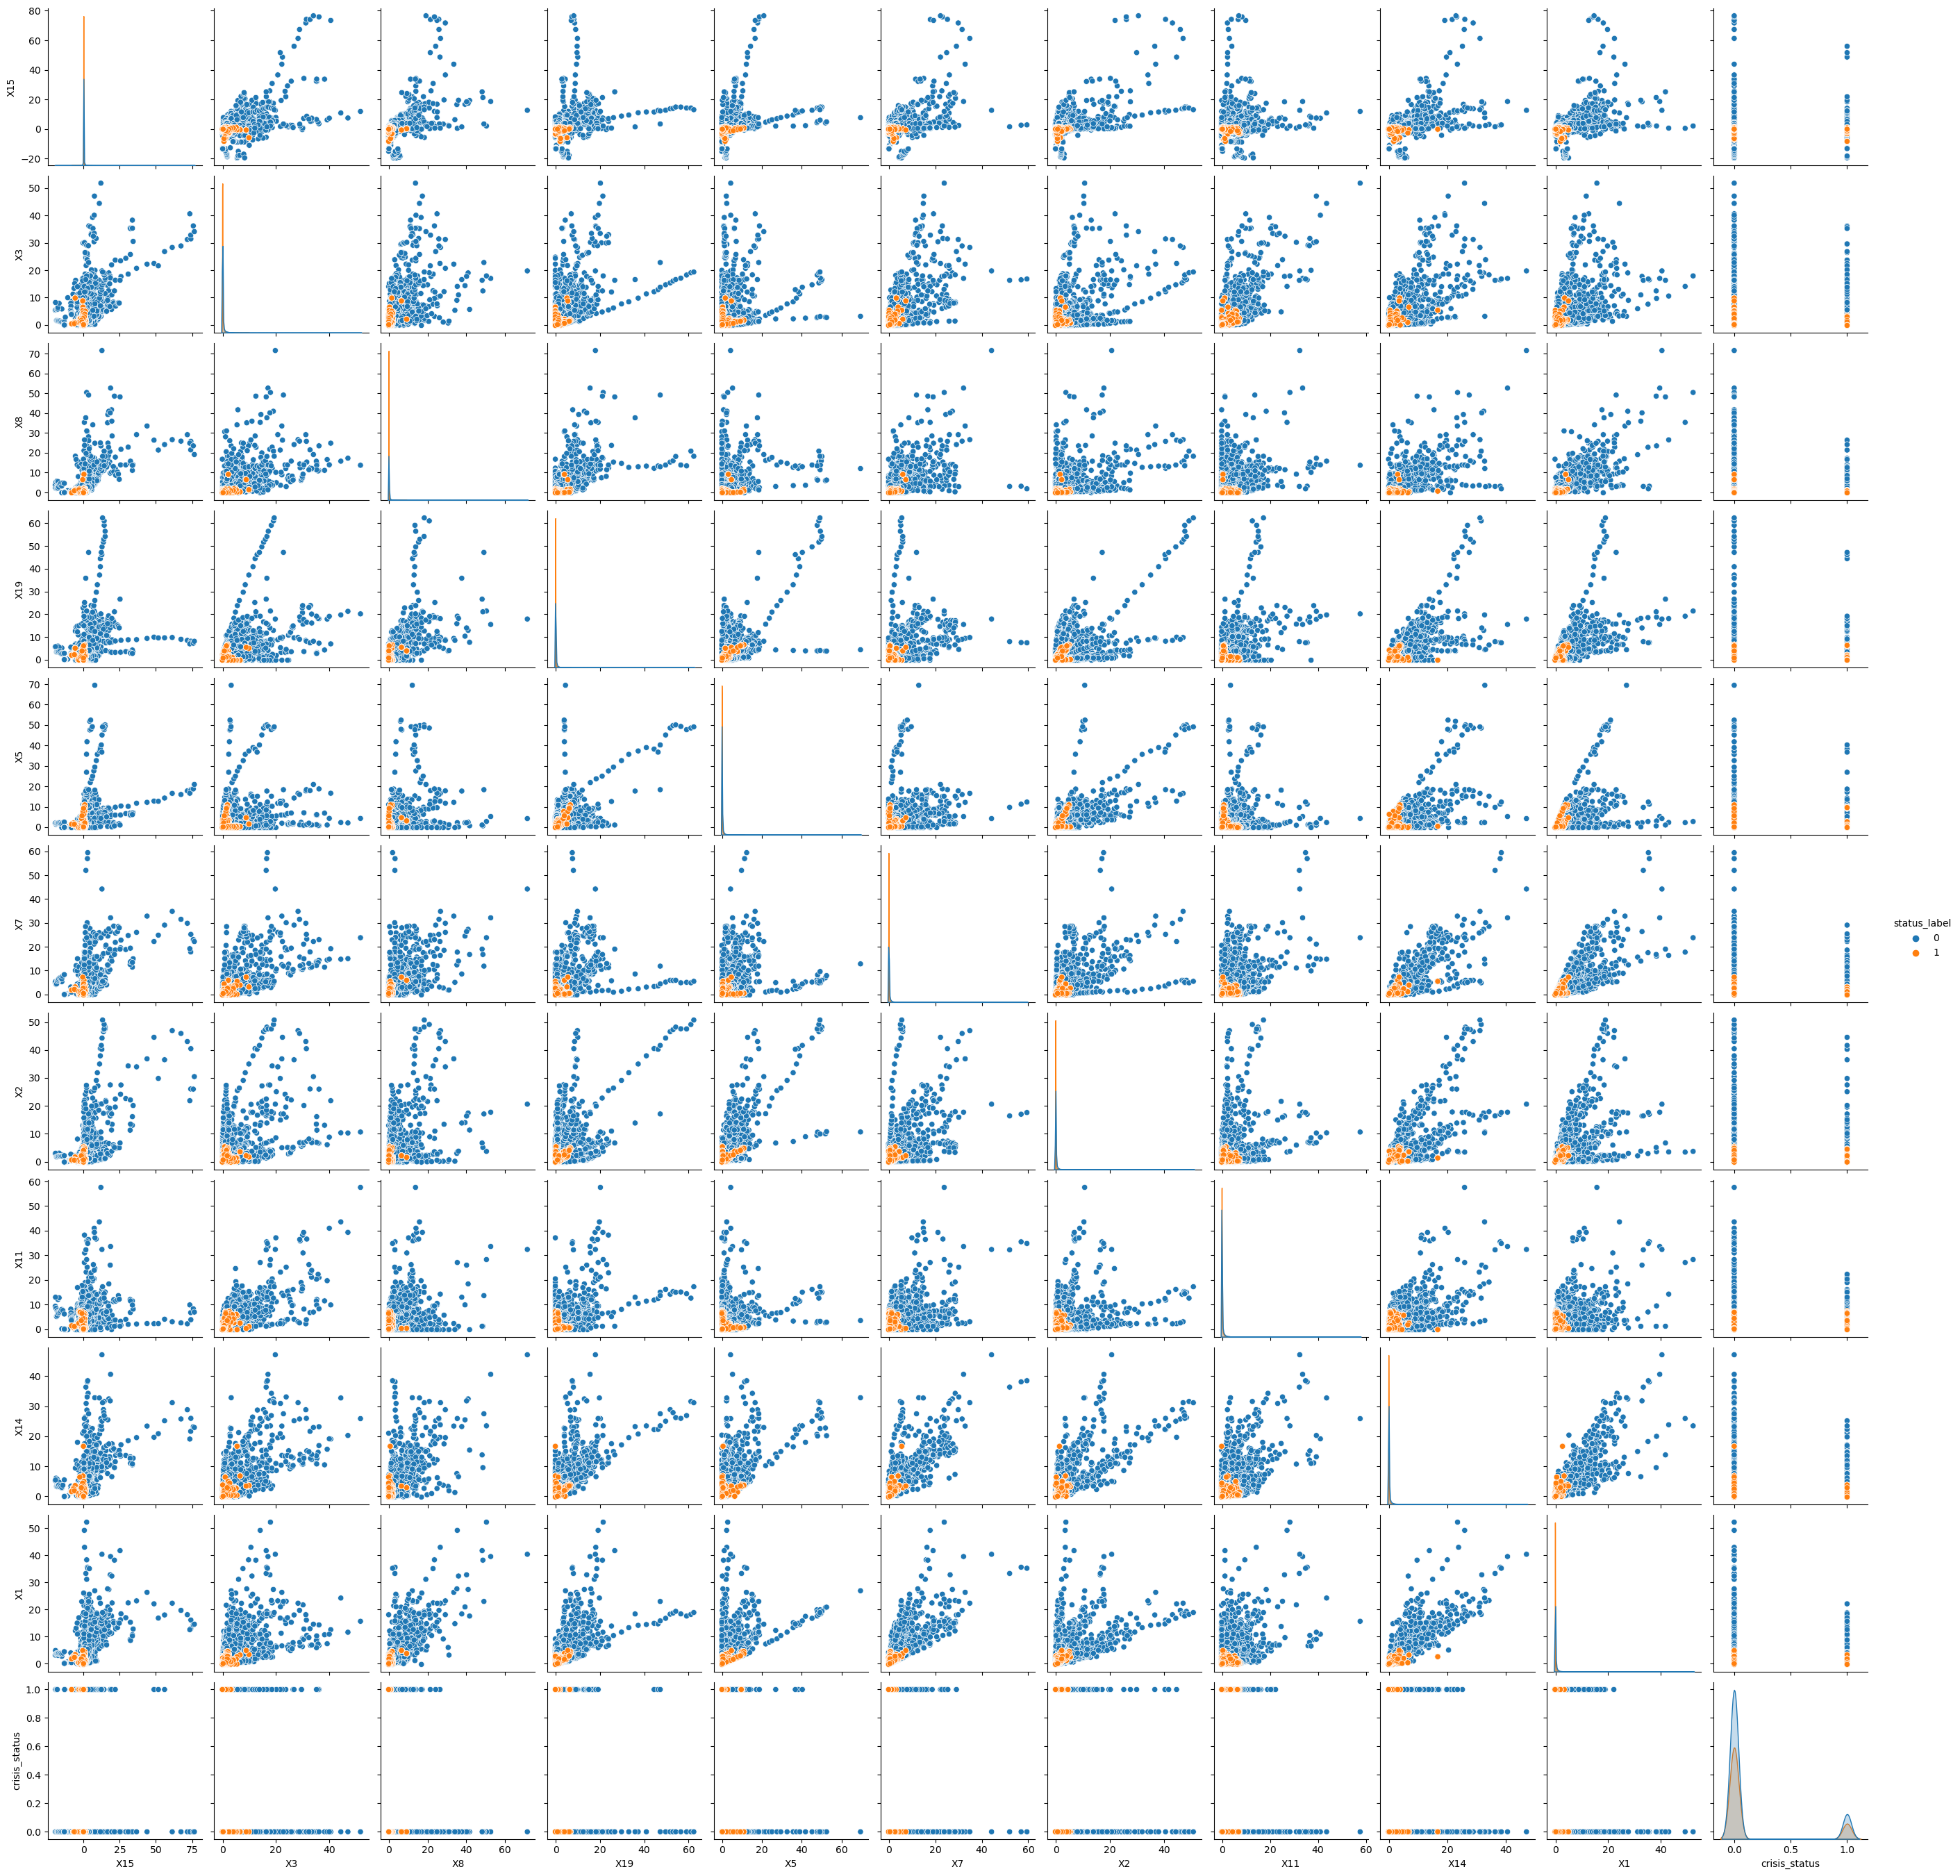

In [30]:
pair_plot = sns.pairplot(df_bank1, hue='status_label')

pair_plot.savefig('pair_plot.png')  

plt.show()

### Create sequences 

In [31]:
import pandas as pd
import numpy as np

df = df_bank1
# Convert 'year' to datetime and sort the DataFrame
df['year'] = pd.to_datetime(df['year'], format='%Y')
df.sort_values(by=['company_name', 'year'], inplace=True)
#display(df)
# This function will create sequences of 5 years for the features and targets
def create_sequences(df, sequence_length=10):
    X = []
    y = []

    # Iterate over the unique companies
    for company in df['company_name'].unique():
        company_data = df[df['company_name'] == company]
        for i in range(len(company_data) - sequence_length*2 + 1):
            # Select sequence_length years of data for the company
            X.append(company_data.iloc[i:i+sequence_length].drop(['company_name', 'status_label', 'year'], axis=1).values)
            # The target is the status in the next sequence_length years
            y.append(company_data.iloc[i+sequence_length:i+sequence_length+5]['status_label'].values)

    X = np.array(X)
    y = np.array(y)
    return X, y

# Apply the function to your data
X, y = create_sequences(df)

# Now X is your input sequences and y is the corresponding target sequences
# You can use these in a machine learning model as you see fit.


/var/folders/rl/kc6hr2p926d9tcc4f27w9crm0000gn/T/ipykernel_5546/632267442.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = pd.to_datetime(df['year'], format='%Y')
/var/folders/rl/kc6hr2p926d9tcc4f27w9crm0000gn/T/ipykernel_5546/632267442.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=['company_name', 'year'], inplace=True)


In [32]:
X.shape

(38681, 10, 11)

In [33]:
y.shape

(38681, 5)

### LSTM Model

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, Dropout, Flatten
from tensorflow.keras.regularizers import l2

def get_model_deep(shape=(10, 11)):
    inp = Input(shape)
    x = LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(Dense(64, activation='relu'))(x)
    x = TimeDistributed(Dense(10, activation='relu'))(x)  
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(5, activation='sigmoid')(x) 
    model = Model(inputs=inp, outputs=x)
    return model


In [35]:
model = get_model_deep((10,11))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

### Split training and test datasets

In [36]:
from sklearn.model_selection import train_test_split
train_X, test_X,train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [37]:
test_y.shape


(7737, 5)

### Model training 

In [38]:
model.fit(train_X, train_y, batch_size=64, epochs=20)

Epoch 1/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.1308 - loss: 0.9372
Epoch 2/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2318 - loss: 0.1130
Epoch 3/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.1311 - loss: 0.0789
Epoch 4/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.0899 - loss: 0.0693
Epoch 5/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.0525 - loss: 0.0668
Epoch 6/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.0429 - loss: 0.0594
Epoch 7/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.0320 - loss: 0.0504
Epoch 8/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.0346 - loss: 0.0457
Epoch 9/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.0441 - loss: 0.0496
Epoch 10/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.0281 - loss: 0.0403
Epoch 11/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.0364 - loss: 0.0404
Epoch 12/20
484/484 ━━━━━━━━━━━━━━━━━━━━

In [39]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 64)         │         4,160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 10)         │           650 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380,747 (1.45 MB)

 Trainable params: 126,787 (495.26 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 253,576 (990.54 KB)

### Saving the model 

In [40]:
from datetime import datetime
from keras.models import load_model

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model.save(f'lstmfinal_{timestamp}.keras')

In [41]:
output = model.predict(test_X, batch_size=64,verbose=1)

121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


In [42]:
binary_predictions = (output >= 0.5).astype(int)

In [43]:
binary_predictions

array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       ...,
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]])

In [44]:
test_y

array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       ...,
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]])

### Model Evaluation 

In [45]:
accuracy = np.mean(binary_predictions == test_y)

print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.99


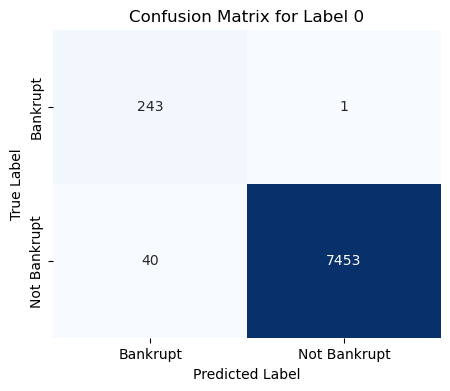

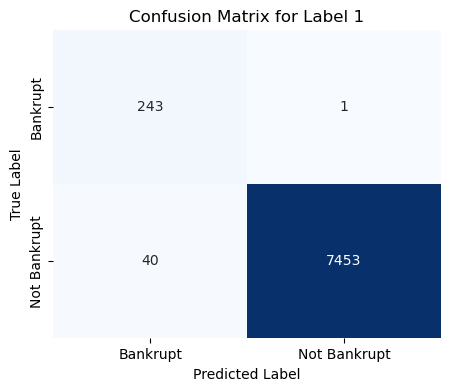

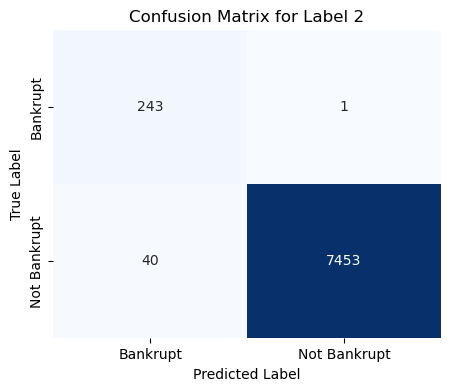

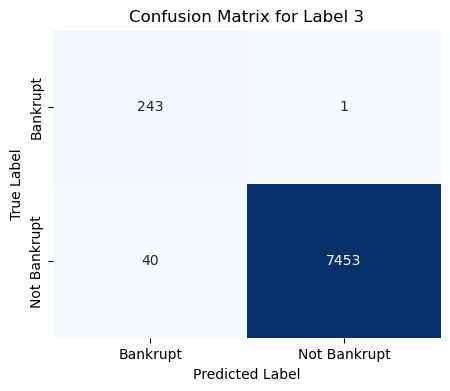

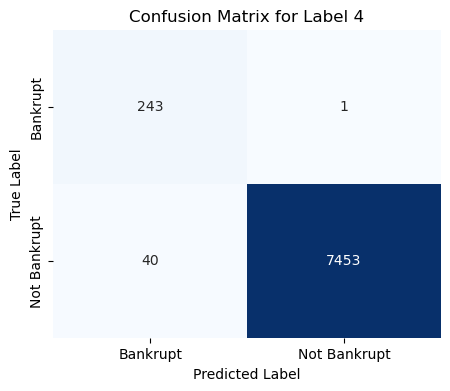

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import numpy as np

# Assuming 'output' is your predicted probabilities and 'test_y' are the true labels.
# Convert probabilities to binary predictions
binary_predictions = (output >= 0.5).astype(int)

# Calculate the multilabel confusion matrix
mcm = multilabel_confusion_matrix(test_y, binary_predictions)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, index, labels=['Bankrupt', 'Not Bankrupt'], title='Confusion Matrix'):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f"{title} for Label {index}")
    plt.show()

# Plotting each label's confusion matrix
for idx, matrix in enumerate(mcm):
    plot_confusion_matrix(matrix, idx)


### Transformer model

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization

def get_model_transformer(shape=(10, 11)):
    inp = Input(shape)
    # Encoder part
    attn_out = MultiHeadAttention(num_heads=2, key_dim=17)(inp, inp)
    attn_out = Dropout(0.1)(attn_out)
    out = LayerNormalization(epsilon=1e-6)(inp + attn_out)
    x = Flatten()(out)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(5, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=x)
    return model


In [49]:
model_t = get_model_transformer((10,11))
model_t.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
model_t.fit(train_X, train_y, batch_size=64, epochs=10)

Epoch 1/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3358 - loss: 0.1519
Epoch 2/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2809 - loss: 0.0273
Epoch 3/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2738 - loss: 0.0219
Epoch 4/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2364 - loss: 0.0193
Epoch 5/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2413 - loss: 0.0181
Epoch 6/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2595 - loss: 0.0161
Epoch 7/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2030 - loss: 0.0155
Epoch 8/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1847 - loss: 0.0158
Epoch 9/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2067 - loss: 0.0161
Epoch 10/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1497 - loss: 0.0144


In [51]:
from datetime import datetime
from keras.models import load_model

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model_t.save(f'transformer_{timestamp}.keras')

In [58]:
model_t.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 11)    │      1,609 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 10, 11)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 11)    │          0 │ input_layer_1[0]… │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 11)    │         22 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 110)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      7,104 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 5)         │        325 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,182 (106.18 KB)

 Trainable params: 9,060 (35.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,122 (70.79 KB)

In [52]:
output = model_t.predict(test_X, batch_size=64,verbose=1)

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [53]:
binary_predictions = (output >= 0.5).astype(int)

In [54]:
accuracy = np.mean(binary_predictions == test_y)

print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.99


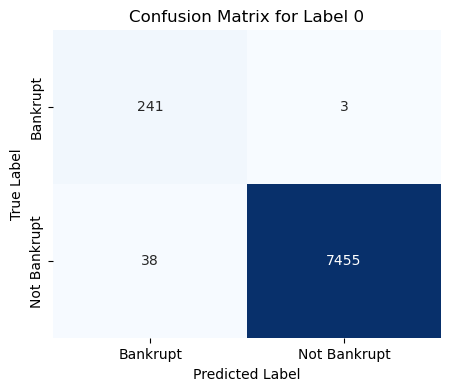

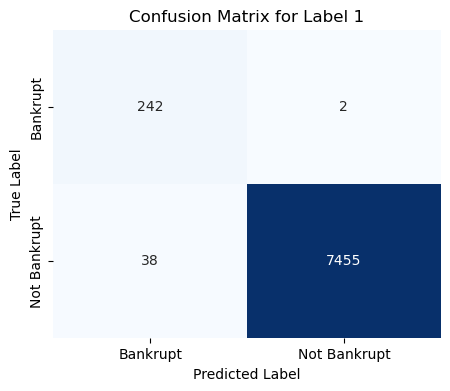

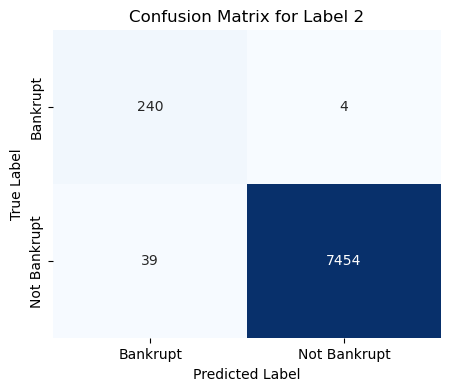

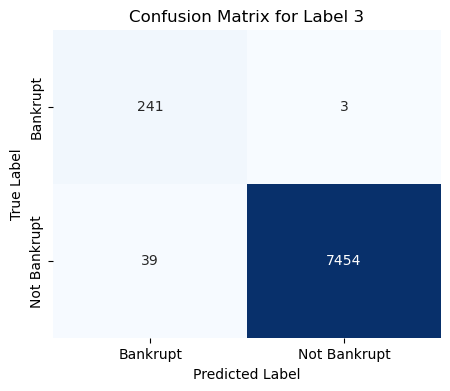

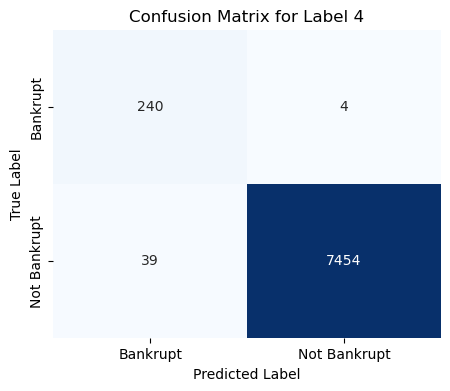

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import numpy as np

# Assuming 'output' is your predicted probabilities and 'test_y' are the true labels.
# Convert probabilities to binary predictions
binary_predictions = (output >= 0.5).astype(int)

# Calculate the multilabel confusion matrix
mcm = multilabel_confusion_matrix(test_y, binary_predictions)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, index, labels=['Bankrupt', 'Not Bankrupt'], title='Confusion Matrix'):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f"{title} for Label {index}")
    plt.show()

# Plotting each label's confusion matrix
for idx, matrix in enumerate(mcm):
    plot_confusion_matrix(matrix, idx)


### GRU Model 

In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
def build_gru_model(input_shape, output_units):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(64, return_sequences=False),
        Dropout(0.2),
        Dense(output_units, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
    return model


In [60]:

# Determine input shape (features, time steps)
input_shape = (X.shape[1], X.shape[2])  # Sequence length and number of features
output_units = y.shape[1]  # Number of years to predict

# Build the model
model = build_gru_model(input_shape, output_units)
model.summary()
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 10, 64)         │        14,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,069 (156.52 KB)

 Trainable params: 40,069 (156.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
967/967 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1530 - val_loss: 0.0211
Epoch 2/10
967/967 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0176 - val_loss: 0.0168
Epoch 3/10
967/967 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0175 - val_loss: 0.0211
Epoch 4/10
967/967 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0159 - val_loss: 0.0177
Epoch 5/10
967/967 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0164 - val_loss: 0.0174
Epoch 6/10
967/967 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0154 - val_loss: 0.0185
Epoch 7/10
967/967 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0155 - val_loss: 0.0163
Epoch 8/10
967/967 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0160 - val_loss: 0.0169
Epoch 9/10
967/967 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0152 - val_loss: 0.0171
Epoch 10/10
967/967 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0145 - val_loss: 0.0159


In [61]:
output = model.predict(test_X, batch_size=64,verbose=1)

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [62]:
binary_predictions = (output >= 0.5).astype(int)

In [63]:
accuracy = np.mean(binary_predictions == test_y)

print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


In [64]:
from datetime import datetime
from keras.models import load_model

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model.save(f'gru_{timestamp}.keras')

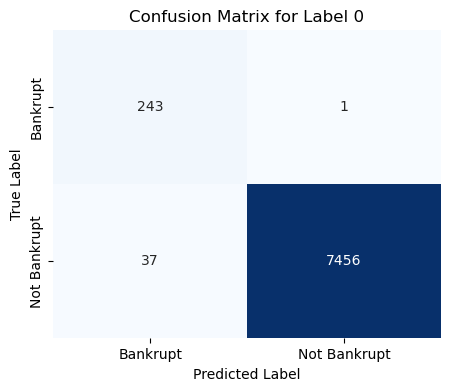

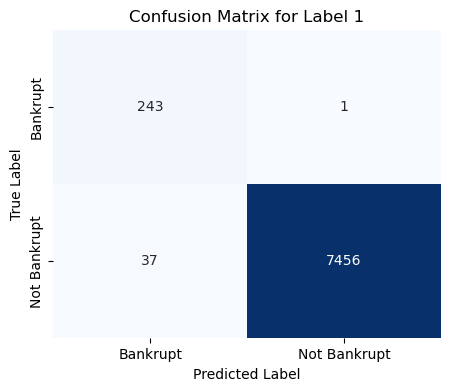

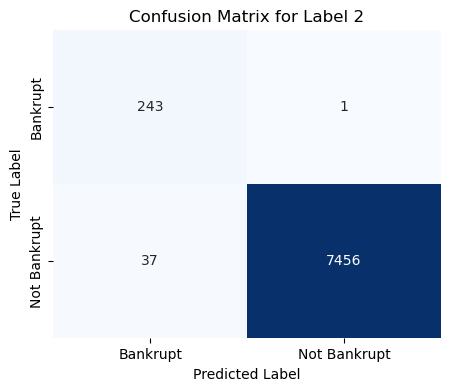

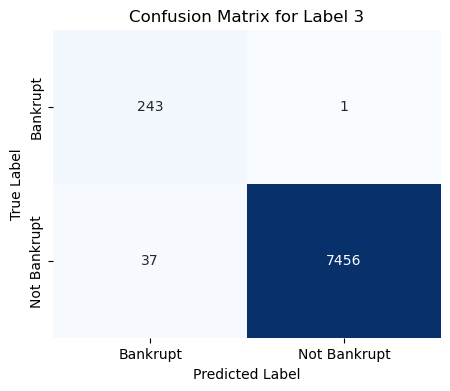

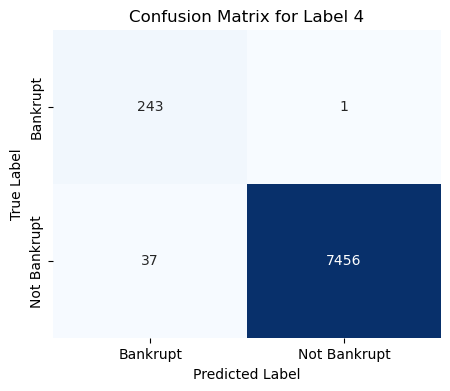

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import numpy as np

# Assuming 'output' is your predicted probabilities and 'test_y' are the true labels.
# Convert probabilities to binary predictions
binary_predictions = (output >= 0.5).astype(int)

# Calculate the multilabel confusion matrix
mcm = multilabel_confusion_matrix(test_y, binary_predictions)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, index, labels=['Bankrupt', 'Not Bankrupt'], title='Confusion Matrix'):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f"{title} for Label {index}")
    plt.show()

# Plotting each label's confusion matrix
for idx, matrix in enumerate(mcm):
    plot_confusion_matrix(matrix, idx)
